In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [4]:
N_EVENTS_SR = 1000
mjjs = pd.read_hdf("/srv/beegfs/scratch/groups/rodem/LHCO/lhco_event_masses.h5").to_numpy(np.float32)
len(mjjs)
mjjs = mjjs[:-100000]
mjjs = mjjs[mjjs > 3300]
mjjs = mjjs[mjjs < 3700]
N_EVENTS_SR = len(mjjs)

In [5]:
# load my curves
my_curver_rej = np.load("/home/users/o/oleksiyu/WORK/hyperproject/workspaces/groups4/TRANSITv1Ano_smooth_no_consistency/plots/compare/transit_rejection_v_TPR_comb_seeds_CWOLA.npy")
my_curve_sic = np.load("/home/users/o/oleksiyu/WORK/hyperproject/workspaces/groups4/TRANSITv1Ano_smooth_no_consistency/plots/compare/transit_SI_v_rej_comb_seeds_CWOLA.npy")
print(my_curver_rej)


[[0.00000000e+00 1.32803888e-05 2.65607777e-05 ... 9.99973439e-01
  9.99986720e-01 1.00000000e+00]
 [           inf            inf            inf ... 1.00024491e+00
  1.00011870e+00 1.00000000e+00]
 [           nan            nan            nan ... 2.27891351e-04
  7.19750174e-05 0.00000000e+00]]


In [6]:
# load my curves
my2_curver_rej = np.load("/home/users/o/oleksiyu/WORK/hyperproject/workspaces/ML4Jets/TRANSITv3f_group/plots/compare/transit_rejection_v_TPR_comb_seeds_CWOLA.npy")
my2_curve_sic = np.load("/home/users/o/oleksiyu/WORK/hyperproject/workspaces/ML4Jets/TRANSITv3f_group/plots/compare/transit_SI_v_rej_comb_seeds_CWOLA.npy")
print(my2_curver_rej)


[[0.00000000e+00 1.32803888e-05 2.65607777e-05 ... 9.99973439e-01
  9.99986720e-01 1.00000000e+00]
 [           inf            inf            inf ... 1.00017106e+00
  1.00010551e+00 1.00000000e+00]
 [           nan            nan            nan ... 1.07672689e-04
  6.63979841e-05 0.00000000e+00]]


In [7]:
# load CURTAINSF4F
npy_file =  "/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_8/seed_0/rejection_v_TPR.npy"
curtains_rej = np.load(npy_file)
npy_file =  "/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_8/seed_0/SI_v_rej.npy"
curtains_sic = np.load(npy_file)

In [8]:
# Load supervised 
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/radot_rej_3000.csv'
# Load the CSV file
radot1 = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/radot_tpr_3000.csv'
# Load the CSV file
radot2 = pd.read_csv(csv_file_path)
# Display the first few rows of the dataframe
print(radot1.head())

        tpr    rej_up  rej_center  rej_down
0  0.000000  121339.0    121339.0  121339.0
1  0.001001  121339.0    121339.0  121339.0
2  0.002002  121339.0    121339.0  121339.0
3  0.003003  121339.0    121339.0  121339.0
4  0.004004  121339.0    121339.0  121339.0


In [9]:
# Load Idealised 
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/rej_vs_tpr_3000_idealised.csv'
ideal_rej = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/sic_vs_reg_3000_idealised.csv'
ideal_sic = pd.read_csv(csv_file_path)

In [10]:
# load RADOT curves
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/rej_vs_tpr_3000_supervised.csv'
# Load the CSV file
super_rej = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/sic_vs_reg_3000_supervised.csv'
# Load the CSV file
super_sic = pd.read_csv(csv_file_path)
# Display the first few rows of the dataframe
print(radot1.head())

        tpr    rej_up  rej_center  rej_down
0  0.000000  121339.0    121339.0  121339.0
1  0.001001  121339.0    121339.0  121339.0
2  0.002002  121339.0    121339.0  121339.0
3  0.003003  121339.0    121339.0  121339.0
4  0.004004  121339.0    121339.0  121339.0


In [11]:
from scipy.interpolate import interp1d
def filter_finite_values(x):
    return x[np.isfinite(x)]

In [12]:
def get_curve(files):
    curves = []
    for file in files:
        curves.append(np.load(file))
    # Aggregate the curves that might have different x values (use interpolation)
    if len(curves) == 1:
        return [curves[0][0], curves[0][1], 0]
    # Sort curves so that x is always rising
    for curve in curves:
        if curve[0][0] > curve[0][-1]:
            curve[0] = curve[0][::-1]
            curve[1] = curve[1][::-1]
        else:
            curve[0] = curve[0]
            curve[1] = curve[1]
    
    # Find the largest x range that all curves have
    min_x = max([filter_finite_values(curve[0])[0] for curve in curves])
    max_x = min([filter_finite_values(curve[0])[-1] for curve in curves])
    
    # get a common x range
    common_x = np.sort(np.unique(np.concatenate([filter_finite_values(curve[0]) for curve in curves])))
    common_x = common_x[(common_x >= min_x) & (common_x <= max_x)]
    
    # Interpolate the y values for each curve
    interpolated_y = []
    for xy in curves:
        x = xy[0]
        y = xy[1]
        interp_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=(y[0], y[-1]))
        interpolated_y.append(interp_func(common_x))
    
    # Convert the list of arrays into a 2D array for easier computation
    interpolated_y = np.array(interpolated_y)

    # Calculate the mean and standard deviation at each x-value
    y_up = np.percentile(interpolated_y, 84, axis=0)
    y_center = np.percentile(interpolated_y, 50, axis=0)
    y_down = np.percentile(interpolated_y, 16, axis=0)
    
    mean_y = np.mean(interpolated_y, axis=0)
    std_y = np.std(interpolated_y, axis=0)
            
    return {"x": common_x, "mean_y": mean_y, "std_y": std_y, "y_up": y_up, "y_down": y_down, "y_center": y_center}

In [13]:
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/standard/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
RADOT_curve = get_curve(files)
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/supervised/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
supervised_curve = get_curve(files)
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/idealised/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
idealised_curve = get_curve(files)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [27]:
RADOT_curve["y_down"]

array([       nan,        nan,        nan, ..., 1.00241858, 1.0012173 ,
       1.        ])

In [28]:
RADOT_curve["y_up"]

array([       nan,        nan,        nan, ..., 1.00613699, 1.00432875,
       1.        ])

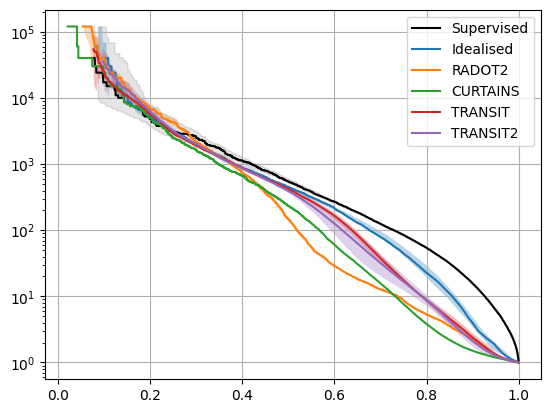

In [14]:
plt.figure()
# plt.plot(super_rej["x"], super_rej["y_center"], label="Supervised", color="black")
# plt.fill_between(super_rej["x"], super_rej["y_down"], super_rej["y_up"], alpha=0.1, color="black")
# plt.plot(ideal_rej["x"], ideal_rej["y_center"], label="Idealised")
# plt.fill_between(ideal_rej["x"], ideal_rej["y_down"], ideal_rej["y_up"], alpha=0.3)
# plt.plot(radot1["tpr"], radot1["rej_center"], label="RADOT")
# plt.fill_between(radot1["tpr"], radot1["rej_down"], radot1["rej_up"], alpha=0.3)

plt.plot(supervised_curve["x"], supervised_curve["y_center"], label="Supervised", color="black")
plt.fill_between(supervised_curve["x"], supervised_curve["y_down"], supervised_curve["y_up"], alpha=0.1, color="black")
plt.plot(idealised_curve["x"], idealised_curve["y_center"], label="Idealised")
plt.fill_between(idealised_curve["x"], idealised_curve["y_down"], idealised_curve["y_up"], alpha=0.3)
plt.plot(RADOT_curve["x"], RADOT_curve["y_center"], label="RADOT2")
plt.fill_between(RADOT_curve["x"], RADOT_curve["y_down"], RADOT_curve["y_up"], alpha=0.3)

plt.plot(curtains_rej[0], curtains_rej[1], label="CURTAINS")
plt.fill_between(curtains_rej[0], curtains_rej[1]-0, curtains_rej[1]+0, alpha=0.3)
plt.plot(my_curver_rej[0], my_curver_rej[1], label="TRANSIT")
plt.fill_between(my_curver_rej[0], my_curver_rej[1]-my_curver_rej[2], my_curver_rej[1]+my_curver_rej[2], alpha=0.3)
plt.plot(my2_curver_rej[0], my2_curver_rej[1], label="TRANSIT2")
plt.fill_between(my2_curver_rej[0], my2_curver_rej[1]-my2_curver_rej[2], my2_curver_rej[1]+my2_curver_rej[2], alpha=0.3)
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig("/home/users/o/oleksiyu/WORK/hyperproject/plots/final2/inverse_rej.png")

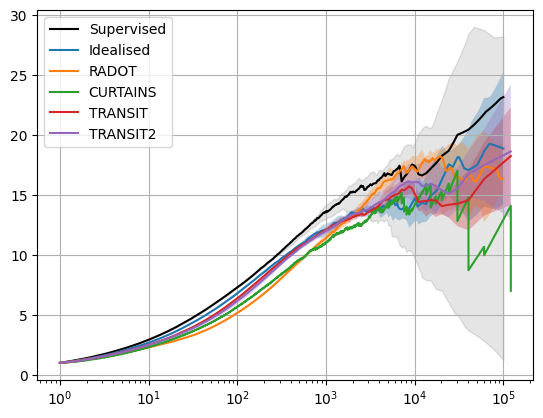

In [15]:
plt.figure()
plt.plot(super_sic["x"], super_sic["y_center"], label="Supervised", color="black")
plt.fill_between(super_sic["x"], super_sic["y_down"], super_sic["y_up"], alpha=0.1, color="black")
plt.plot(ideal_sic["x"], ideal_sic["y_center"], label="Idealised")
plt.fill_between(ideal_sic["x"], ideal_sic["y_down"], ideal_sic["y_up"], alpha=0.3)
plt.plot(radot2["rejection"], radot2["tpr_center"], label="RADOT")
plt.fill_between(radot2["rejection"], radot2["tpr_down"], radot2["tpr_up"], alpha=0.3)
plt.plot(curtains_sic[0], curtains_sic[1], label="CURTAINS")
plt.fill_between(curtains_sic[0], curtains_sic[1]-0, curtains_sic[1]+0, alpha=0.3)
plt.plot(my_curve_sic[0], my_curve_sic[1], label="TRANSIT")
plt.fill_between(my_curve_sic[0], my_curve_sic[1]-my_curve_sic[2], my_curve_sic[1]+my_curve_sic[2], alpha=0.3)
plt.plot(my2_curve_sic[0], my2_curve_sic[1], label="TRANSIT2")
plt.fill_between(my2_curve_sic[0], my2_curve_sic[1]-my2_curve_sic[2], my2_curve_sic[1]+my2_curve_sic[2], alpha=0.3)
plt.xscale("log")
plt.grid()
plt.legend()
plt.savefig("/home/users/o/oleksiyu/WORK/hyperproject/plots/final2/SIC.png")

In [16]:
def linear_interpolation(x, y, x_new):
    # Convert lists to numpy arrays for easier manipulation
    x = np.array(x)
    y = np.array(y)

    # Ensure that x_new is within the range of x
    if x_new < np.min(x) or x_new > np.max(x):
        raise ValueError("x_new is out of bounds of x.")

    # Find indices of the two closest values in x that bound x_new
    idx = np.searchsorted(x, x_new)
    
    # Handle edge case where x_new matches exactly the smallest or largest x value
    if x_new == x[idx - 1]:
        return y[idx - 1]
    elif x_new == x[idx]:
        return y[idx]

    # Get the two x and y values surrounding x_new
    x0, x1 = x[idx - 1], x[idx]
    y0, y1 = y[idx - 1], y[idx]

    # Perform linear interpolation
    y_new = y0 + (y1 - y0) * (x_new - x0) / (x1 - x0)

    return y_new

## Plot the SI vs Rejection curves

In [17]:
folder = "/home/users/o/oleksiyu/WORK/hyperproject/workspaces/DOPING/TRANSITv1_dopings"
dopings = [50, 100, 333, 500, 667, 1000, 3000]

In [18]:
SI_vs_rejinv_curves = []
def get_y_and_std_curves(curves, x):
    y = []
    for curve in curves:
        y += [linear_interpolation(curve[0], curve[1], x)]
    return np.mean(y), np.std(y)

In [19]:
n_dope_per_run=[0, 50, 100, 333, 500, 667, 1000, 3000]
runs = [0, 1, 2, 4, 5, 6, 7, 8]
def getSI_vs_doping_CURTAINS(target_inv_rej):
    # plt.figure()
    SIs =[]
    SI_stds = []
    for run, doping in zip(runs, n_dope_per_run):
        SI_rejs = []
        for seed in range(5):
            SI_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_{run}/seed_{seed}/SI_v_rej.npy"
            SI_rej = np.load(SI_curve_file)
            SI_rej[0] = np.flip(SI_rej[0])
            SI_rej[1] = np.flip(SI_rej[1])
            SI_rejs += [SI_rej]
        y, y_std = get_y_and_std_curves(SI_rejs, target_inv_rej)
        SIs += [y]
        SI_stds += [y_std]
    return SIs, SI_stds

In [20]:
SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_CURTAINS(100)
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "CURTAINS",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_CURTAINS(1000)
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "CURTAINS",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

In [21]:
# get curves for curtains
n_dope_per_run=[0, 50, 100, 333, 500, 667, 1000, 3000]

SIs_CURTAINS_100 = []
SIs_CURTAINS_1000 = []

def getSI_vs_doping_RADOT(target_inv_rej, mode="standard"):
    # plt.figure()
    SIs =[]
    SI_stds = []
    for run, doping in zip(runs, n_dope_per_run):
        SI_rejs = []
        for seed in range(5):
            SI_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_{doping}/{mode}/seed_{seed}/SI_v_rej.npy"
            SI_rej = np.load(SI_curve_file)
            SI_rej[0] = np.flip(SI_rej[0])
            SI_rej[1] = np.flip(SI_rej[1])
            SI_rejs += [SI_rej]
            #plt.plot(SI_rej[0], SI_rej[1], label=f"{doping}")
        y, y_std = get_y_and_std_curves(SI_rejs, target_inv_rej)
        SIs += [y]
        SI_stds += [y_std]
    # plt.grid()
    # plt.ylabel("SI")
    # plt.xlabel("1/Rejection rate")
    # plt.axvline(100, color='black')
    # plt.xscale('log')
    # plt.legend()
    return SIs, SI_stds



SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "supervised")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "Supervised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err),
                         "color": "black"}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "supervised")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "Supervised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err),
                         "color": "black"}]

SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "idealised")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "Idealised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "idealised")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "Idealised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "standard")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "RADOT",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "standard")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "RADOT",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

In [22]:
def getSI_vs_doping_curve_TRANSIT(target_inv_rej):
    SIs = []
    SI_errs = []
    for doping in dopings:
        SI_curve_file = f"{folder}/run-doping_{doping}/plots/compare/transit_SI_v_rej_comb_seeds_CWOLA.npy"
        SI_rej = np.load(SI_curve_file)
        rej_inv = SI_rej[0]
        SI = SI_rej[1]
        SI_err = SI_rej[2]
        #plt.plot(rej_inv, SI, marker='o', label=f"{doping}")
        SIs.append(linear_interpolation(rej_inv, SI, target_inv_rej))
        SI_errs.append(linear_interpolation(rej_inv, SI_err, target_inv_rej))
    return np.array(SIs), np.array(SI_errs)

In [23]:
SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(100)
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "TRANSIT",
                         "x": np.array(dopings),
                         "y": SIs,
                         "y_err": SI_errs}]

In [24]:
SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(1000)
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "TRANSIT",
                         "x": dopings,
                         "y": SIs,
                         "y_err": SI_errs}]

{'tags': ['invrej_100'], 'label': 'CURTAINS', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([0.15989631, 0.36927532, 0.48729747, 1.38830711, 2.06130605,
       2.58947174, 3.75963996, 5.68370597]), 'y_err': array([0.07615349, 0.09965769, 0.16716174, 0.10859745, 0.23419429,
       0.24927339, 0.1547733 , 0.046288  ])}
{'tags': ['invrej_100'], 'label': 'Supervised', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([       nan, 4.7560628 , 6.02377145, 6.77916023, 6.92543048,
       7.02266941, 7.06274953, 7.29340341]), 'y_err': array([       nan, 0.45006002, 0.22043942, 0.08354678, 0.05856319,
       0.06208872, 0.08149088, 0.01620175]), 'color': 'black'}
{'tags': ['invrej_100'], 'label': 'Idealised', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([0.05633537, 0.16170196, 0.53692605, 2.53854612, 4.10039961,
       4.98646696, 5.7231302 , 6.83217552]), 'y_err': array([0.06063091, 0.17617793, 0.71968111, 0.93091884

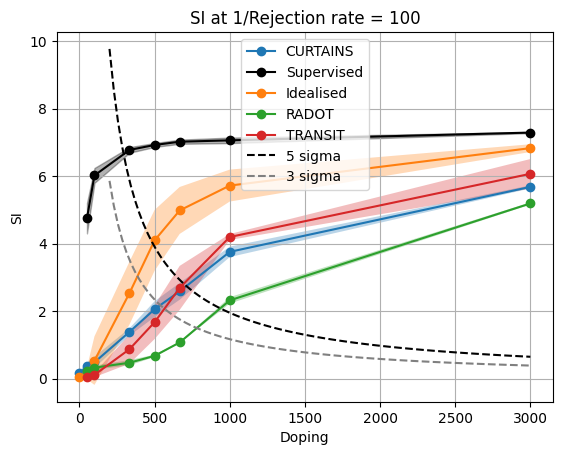

In [25]:
rej_target = 100
curve_order = ["Supervised", "Idealised", "CURTAINS", "RADOT", "TRANSIT"]
for curve in SI_vs_rejinv_curves:
    if f"invrej_{rej_target}" in curve["tags"]:
        print(curve)
        plt.plot(curve["x"], curve["y"], marker='o', label=curve["label"], color = curve.get("color", None))
        if curve.get("color", None) is not None:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3, color = curve["color"])
        else:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3)
plt.grid()
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 5/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="black", label="5 sigma", linestyle="--")
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 3/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="gray", label="3 sigma", linestyle="--")
plt.ylabel("SI")
plt.xlabel("Doping")
plt.title(f"SI at 1/Rejection rate = {rej_target}")
plt.legend()

{'tags': ['invrej_1000'], 'label': 'CURTAINS', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([ 0.04854918,  0.05014942,  0.14817096,  1.21768288,  2.26648121,
        3.69879674,  6.56688776, 11.02916168]), 'y_err': array([0.03518622, 0.02829857, 0.06022399, 0.21626019, 0.51226952,
       0.57557767, 0.44212342, 0.2892685 ])}
{'tags': ['invrej_1000'], 'label': 'Supervised', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([        nan,  4.45216643,  9.99517426,  9.40730374, 12.66804366,
       12.19796346, 11.48285221, 13.24014109]), 'y_err': array([       nan, 0.77761548, 1.65325205, 4.69513488, 0.60850699,
       0.81017387, 0.76856844, 0.46258479]), 'color': 'black'}
{'tags': ['invrej_1000'], 'label': 'Idealised', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([2.25431830e-03, 3.11565959e-02, 6.28092750e-01, 2.96683788e+00,
       5.28009788e+00, 9.67483193e+00, 1.06612386e+01, 1.20742427e+01]), 'y_err': ar

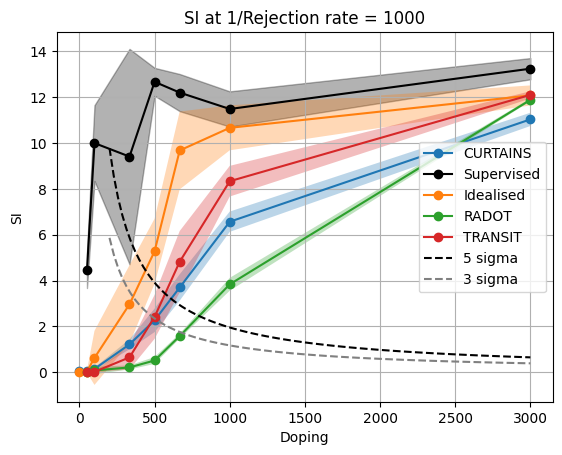

In [26]:

rej_target = 1000
curve_order = ["Supervised", "Idealised", "CURTAINS", "RADOT", "TRANSIT"]
for curve in SI_vs_rejinv_curves:
    if f"invrej_{rej_target}" in curve["tags"]:
        print(curve)
        plt.plot(curve["x"], curve["y"], marker='o', label=curve["label"], color = curve.get("color", None))
        if curve.get("color", None) is not None:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3, color = curve["color"])
        else:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3)
plt.grid()
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 5/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="black", label="5 sigma", linestyle="--")
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 3/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="gray", label="3 sigma", linestyle="--")
plt.ylabel("SI")
plt.xlabel("Doping")
plt.title(f"SI at 1/Rejection rate = {rej_target}")
plt.legend()